<a href="https://colab.research.google.com/github/Jeet1309/AI-ML-tss/blob/main/303ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeetgurbani","key":"a02696361cdb7a16a07e42a16004510a"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy

Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): apache-2.0


In [4]:
!unzip best-alzheimer-mri-dataset-99-accuracy.zip


Streaming output truncated to the last 5000 lines.
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1106).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1107).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1108).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1109).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (111).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1110).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1111).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1112).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1113).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1114).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1115).jpg  
  inflating: Combined Dataset/train/No Impairment/NoImpairment (1116).jpg  
  inflating: Combined Dataset/train/No

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, LeakyReLU,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
dataset_dir = '/content/Combined Dataset/train'
img_height, img_width = 128, 128
batch_size = 32
seed = 42

# Load image paths and labels, excluding "Very Mild Impairment"
filepaths = []
labels = []

for class_name in os.listdir(dataset_dir):
    if class_name == "Very Mild Impairment":
        continue  # Skip this class
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(class_name)

# Create dataframe
df = pd.DataFrame({
    'filename': filepaths,
    'class': labels
})

# Split the dataset: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['class'], random_state=seed)

# ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=seed
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=seed
)

# Test generator
test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=seed
)


Found 6144 validated image filenames belonging to 3 classes.
Found 768 validated image filenames belonging to 3 classes.
Found 768 validated image filenames belonging to 3 classes.


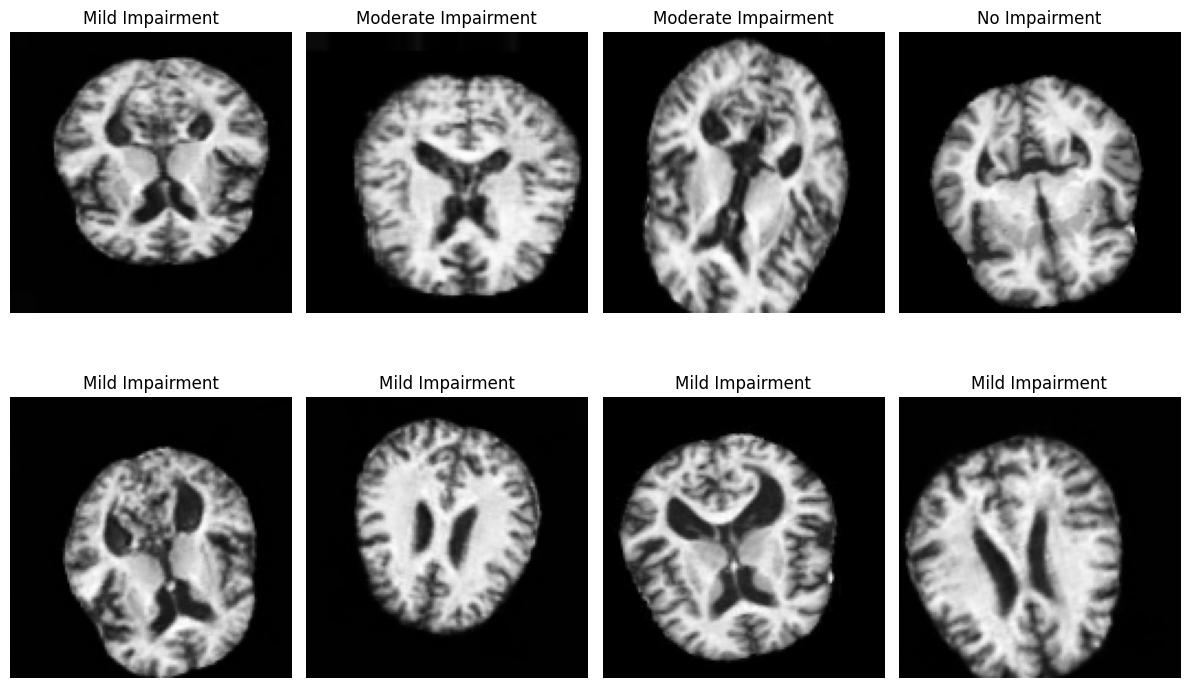

In [7]:
class_names = list(train_generator.class_indices.keys())
images, labels = next(train_generator)  # Get one batch

plt.figure(figsize=(12, 8))
for i in range(8):  # Show 8 images
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # squeeze in case of (128,128,1)
    label_idx = np.argmax(labels[i])
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),

        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu',padding='same'),
        Conv2D(64, (3,3), activation='relu',padding='same'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu',padding='same'),
        Conv2D(128, (3,3), activation='relu',padding='same'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        Conv2D(128, (3,3), activation='relu',padding='same'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu',padding='same'),
        Conv2D(256, (3,3), activation='relu',padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dropout(0.2),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),


        Dense(3, activation='softmax')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
OPT = tf.keras.optimizers.RMSprop()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.F1Score()]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 31, 31, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,605,571 (6.12 MB)

 Trainable params: 1,605,443 (6.12 MB)

 Non-trainable params: 128 (512.00 B)

In [10]:
earlystopping = EarlyStopping(monitor = 'val_loss',
                              mode = 'min',
                              patience = 80,
                              verbose = 1)

filepath = './best.weights.h5'

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_loss',
                                mode='min',
                                save_best_only=True,
                                save_weights_only=True,
                                verbose = 1)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1)


callback_list = [earlystopping, checkpoint]

In [11]:
# Train
history = model.fit(
    train_generator,
    epochs=90,
    validation_data=val_generator,
    callbacks=callback_list
)

# Save
model.save('alzheimers_cnn_model.h5')

Epoch 1/90


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.5517 - auc: 0.7494 - f1_score: 0.5449 - loss: 0.8885
Epoch 1: val_loss improved from inf to 0.44874, saving model to ./best.weights.h5
192/192 ━━━━━━━━━━━━━━━━━━━━ 29s 86ms/step - acc: 0.5524 - auc: 0.7501 - f1_score: 0.5455 - loss: 0.8875 - val_acc: 0.8542 - val_auc: 0.9598 - val_f1_score: 0.8509 - val_loss: 0.4487
Epoch 2/90
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - acc: 0.8572 - auc: 0.9670 - f1_score: 0.8570 - loss: 0.3516
Epoch 2: val_loss did not improve from 0.44874
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - acc: 0.8572 - auc: 0.9670 - f1_score: 0.8570 - loss: 0.3515 - val_acc: 0.6432 - val_auc: 0.8808 - val_f1_score: 0.6002 - val_loss: 0.8604
Epoch 3/90
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.8741 - auc: 0.9748 - f1_score: 0.8743 - loss: 0.3014
Epoch 3: val_loss improved from 0.44874 to 0.20721, saving model to ./best.weights.h5
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - acc: 0.8741 - auc: 0.9748 - f1_score: 0.

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns
import os

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy: 0.9818
Weighted F1-score: 0.9818

Classification Report:
                     precision    recall  f1-score   support

    Mild Impairment       0.99      0.96      0.97       256
Moderate Impairment       1.00      1.00      1.00       256
      No Impairment       0.96      0.99      0.97       256

           accuracy                           0.98       768
          macro avg       0.98      0.98      0.98       768
       weighted avg       0.98      0.98      0.98       768



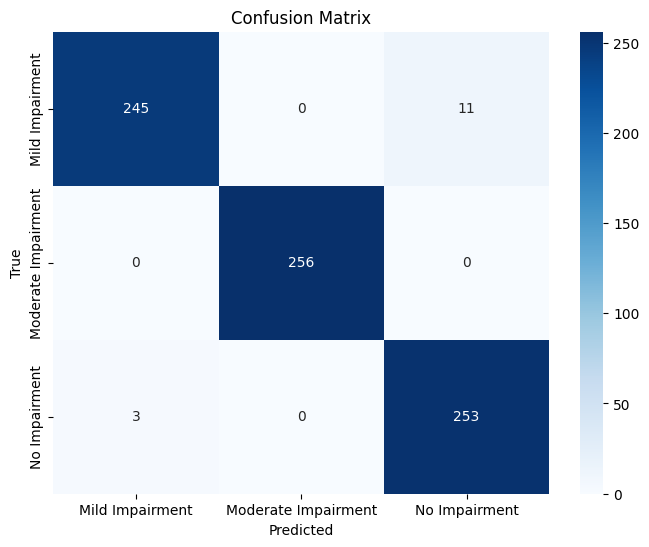

In [13]:
model.load_weights(filepath)

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes

# Class labels
class_names = list(test_generator.class_indices.keys())

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted F1-score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


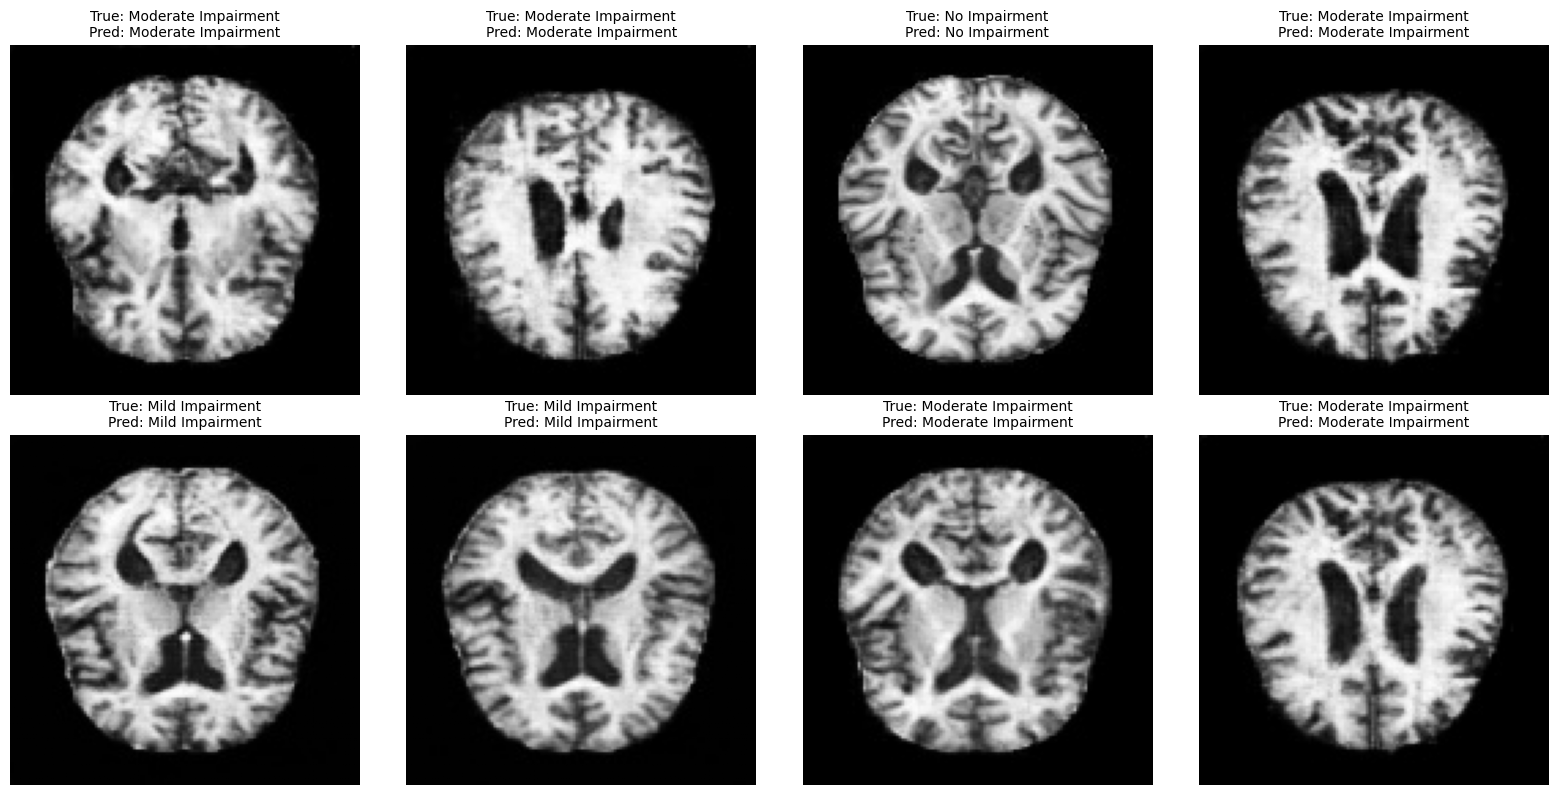

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())
file_paths = test_generator.filepaths

# Pick 8 random indices
random_indices = random.sample(range(len(file_paths)), 8)

plt.figure(figsize=(16, 8))

for i, idx in enumerate(random_indices):
    img_path = file_paths[idx]

    # Load image in grayscale
    img = tf.keras.preprocessing.image.load_img(
        img_path,
        target_size=(img_height, img_width),
        color_mode='grayscale'
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize
    img_array = tf.expand_dims(img_array, axis=0)  # Shape becomes (1, height, width, 1)

    # Make prediction
    pred = model.predict(img_array, verbose=0)
    pred_label = class_names[np.argmax(pred)]
    true_label = class_names[true_classes[idx]]

    # Plotting
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.squeeze(img_array[0]), cmap='gray')  # Show grayscale image
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

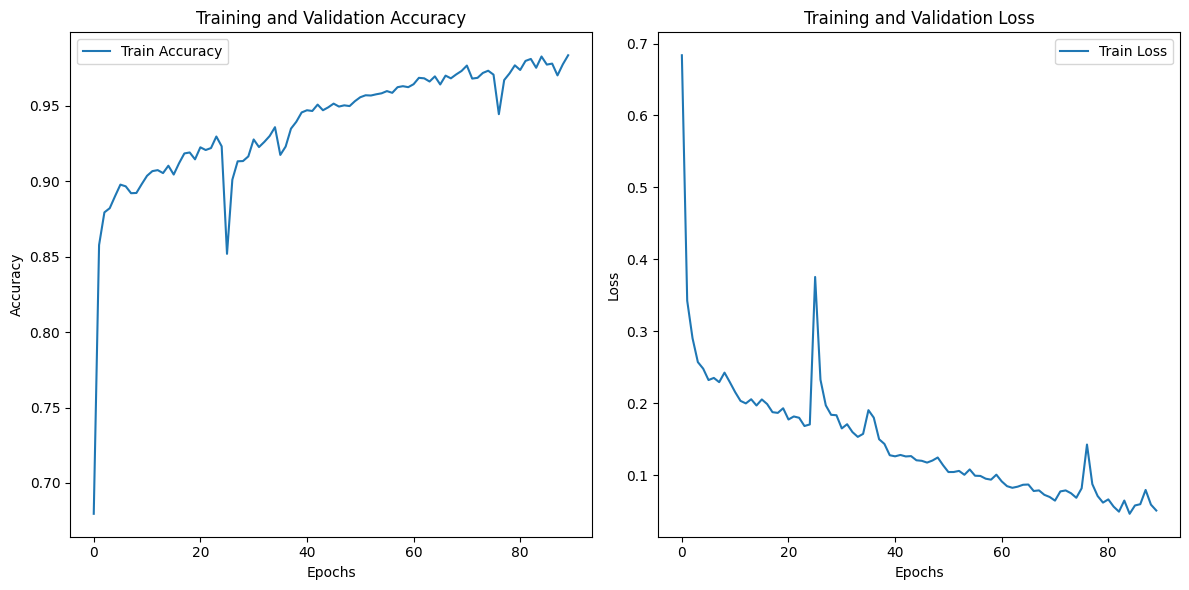

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train Accuracy')             # ← updated
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


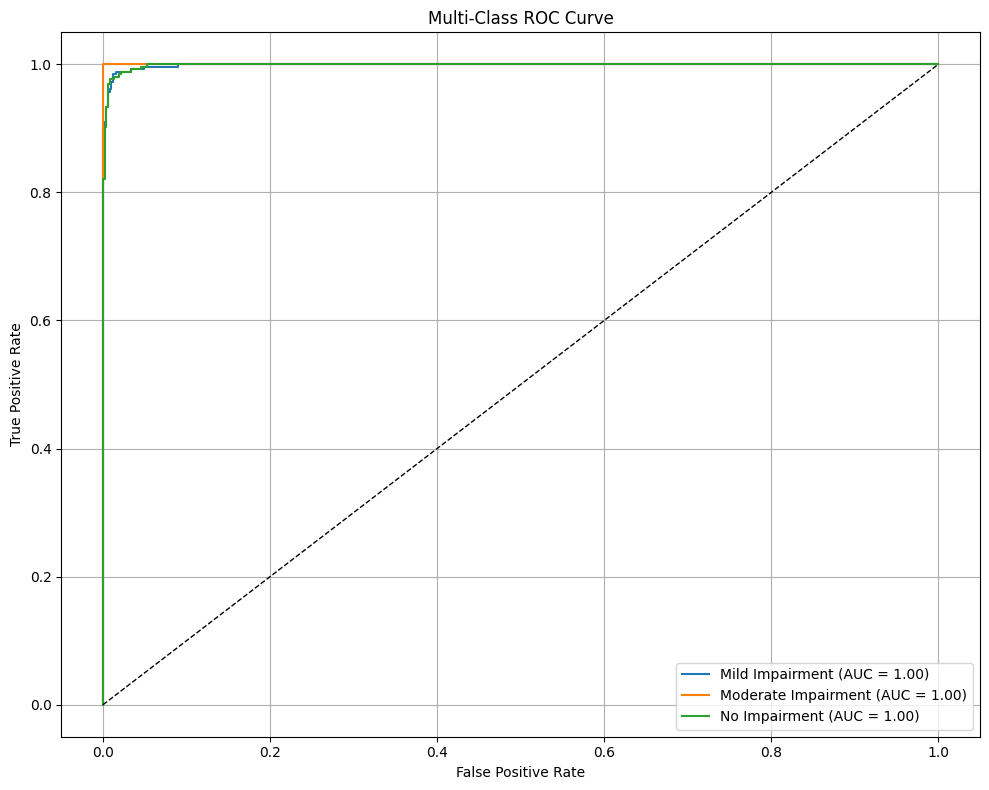

In [16]:
y_pred_proba = model.predict(test_generator, verbose=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Binarize the labels for multi-class AUC
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Plot setup
plt.figure(figsize=(10, 8))

# Compute and plot ROC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()